In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stat
import sklearn as sk3
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Available Local files containing data

investor = "month_InvestorFlow"
monthsData = ["month_CPI", "month_housePrice", "month_longtermInterest"]
yearsData = ["year_educationBudget", "year_empRate", "year_GDP", "year_houseIncome"]

In [3]:
# Create 3 empty dataframes for monthly , yearly and combined monthly-yearly data

df_month = pd.DataFrame()
df_year = pd.DataFrame()
df_all = pd.DataFrame()

In [4]:
# Extract monthly interest rates for monthly interest dataset
# Convert all columns names to lower case and set index column to year and month

df_monthInterest = pd.read_csv("../Data/Original_Data/" + "month_interestRates" + ".csv")
df_monthInterest = df_monthInterest[['Year', 'Month', 'Effective Federal Funds Rate']]
df_monthInterest.columns = map(str.lower, df_monthInterest.columns)

df_monthInterest['federal_funds_rates'] = df_monthInterest["effective federal funds rate"]
df_monthInterest.drop(columns=["effective federal funds rate"], inplace=True)
df_monthInterest.set_index(["year","month"], inplace = True)
df_monthInterest.head()

federal_funds_rates
year month                     
1954 7                     0.80
     8                     1.22
     9                     1.06
     10                    0.85
     11                    0.83

In [5]:
df_monthInterest.head()

federal_funds_rates
year month                     
1954 7                     0.80
     8                     1.22
     9                     1.06
     10                    0.85
     11                    0.83

In [6]:
# Extract year from the date column for monthly datasets
# Convert all columns names to lower case and set index column to year and month
# For the month_housePrice dataset, I add a new column called avg housePrice - the monthly average housePriceIndex accross the states 

count = 0
for monthData in monthsData:
    df=pd.read_csv("../Data/Original_Data/" + monthData + ".csv")
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['month'] = pd.DatetimeIndex(df['Date']).month
    df.columns = map(str.lower, df.columns)
    
    if monthData == "month_housePrice":
        df = df[['year', 'month', 'avghouseprice']] 
    df.set_index(["year","month"], inplace = True)
    
    if count == 0:
        df_month = df
    else:
        df_month = df_month.merge(df, how='outer', left_index=True, right_index=True)
    count += 1
df_month = df_month.merge(df_monthInterest, how='outer', left_index=True, right_index=True)
df_month.tail()

date_x  index  inflation  avghouseprice      date_y  rate  \
year month                                                             
2019 10       NaN    NaN        NaN            NaN  2019-10-09  1.71   
     11       NaN    NaN        NaN            NaN  2019-11-09  1.81   
     12       NaN    NaN        NaN            NaN  2019-12-09  1.86   
2020 1        NaN    NaN        NaN            NaN  2020-01-09  1.76   
     2        NaN    NaN        NaN            NaN  2020-02-09  1.50   

            federal_funds_rates  
year month                       
2019 10                     NaN  
     11                     NaN  
     12                     NaN  
2020 1                      NaN  
     2                      NaN

In [7]:
# Convert all yearly datasets columns names to lowercase and set index column to year

count = 0
for yearData in yearsData:
    df=pd.read_csv("../Data/Original_Data/" + yearData + ".csv")
    df.columns = map(str.lower, df.columns)
    df.set_index("year", inplace = True)
    
    if count == 0:
        df_year = df
    else:
        df_year = df_year.merge(df, left_index=True, right_index=True)
    count += 1
df_year.tail()

,budget_on_education,gdp,ratio,population,labor_force,population_percent,employed_total,employed_percent,agrictulture_ratio,nonagriculture_ratio,...,level-current,level-chained,change-current,change-chained,number (thousands),lowest,second,third,fourth,top 5 percent
year,,,,,,,,,,,,,,,,,,,,,
2006,100019,13855888,0.722,228815,151428,66.2,144427,63.1,2206,142221,...,13855.9,14613.8,4.5,1.8,116011,24418,46038,73126,118260.0,212081
2007,68265,14477635,0.472,231867,153124,66.0,146047,63.0,2095,143952,...,14477.6,14873.7,1.7,-0.3,116783,24048,46340,73480,118516.0,209773
2008,65399,14718582,0.444,233788,154287,66.0,145362,62.2,2168,143194,...,14718.6,14830.4,-2.0,-2.8,117181,23639,44512,71589,114406.0,205438
2009,131891,14418739,0.915,235801,154142,65.4,139877,59.3,2103,137775,...,14418.7,14418.7,3.8,2.5,117538,23425,44151,70781,114530.0,206156
2010,62911,14964372,0.420,237830,153889,64.7,139064,58.5,2206,136858,...,14964.4,14783.8,3.7,1.6,119927,22534,42815,69293,112704.0,203355


In [8]:
# Combine monthly and yearly dataframes to df_all dataframe for statistic models
# dropna() function can be used to drop all NaN values in dataset

df_all = df_month
df_all = df_all.merge(df_year, left_index=True, right_index=True)
# df_all = df_all.dropna()
df_all.head(13)

date_x  index  inflation  avghouseprice      date_y  rate  \
year month                                                                  
1976 1      1976-01-01   55.6       0.18            NaN  1976-01-09  7.74   
     2      1976-02-01   55.8       0.36            NaN  1976-02-09  7.79   
     3      1976-03-01   55.9       0.18            NaN  1976-03-09  7.73   
     4      1976-04-01   56.1       0.36            NaN  1976-04-09  7.56   
     5      1976-05-01   56.5       0.71            NaN  1976-05-09  7.90   
     6      1976-06-01   56.8       0.53            NaN  1976-06-09  7.86   
     7      1976-07-01   57.1       0.53            NaN  1976-07-09  7.83   
     8      1976-08-01   57.4       0.53            NaN  1976-08-09  7.77   
     9      1976-09-01   57.6       0.35            NaN  1976-09-09  7.59   
     10     1976-10-01   57.9       0.52            NaN  1976-10-09  7.41   
     11     1976-11-01   58.0       0.17            NaN  1976-11-09  7.29   
     12     1976-12-01   58.2       0.34            NaN  1976-12-09  6.87   
1977 1      1977-01-01   58.5       0.52            NaN  1977-01-09  7.21   

            federal_funds_rates  budget_on_education      gdp  ratio  ...  \
year month                                                            ...   
1976 1                     4.87                 9314  1877587  0.496  ...   
     2                     4.77                 9314  1877587  0.496  ...   
     3                     4.84                 9314  1877587  0.496  ...   
     4                     4.82                 9314  1877587  0.496  ...   
     5                     5.29                 9314  1877587  0.496  ...   
     6                     5.48                 9314  1877587  0.496  ...   
     7                     5.31                 9314  1877587  0.496  ...   
     8                     5.29                 9314  1877587  0.496  ...   
     9                     5.25                 9314  1877587  0.496  ...   
     10                    5.02                 9314  1877587  0.496  ...   
     11                    4.95                 9314  1877587  0.496  ...   
     12                    4.65                 9314  1877587  0.496  ...   
1977 1                     4.61                10568  2085951  0.507  ...   

            level-current  level-chained  change-current  change-chained  \
year month                                                                 
1976 1             1877.6         5675.4            11.1             4.6   
     2             1877.6         5675.4            11.1             4.6   
     3             1877.6         5675.4            11.1             4.6   
     4             1877.6         5675.4            11.1             4.6   
     5             1877.6         5675.4            11.1             4.6   
     6             1877.6         5675.4            11.1             4.6   
     7             1877.6         5675.4            11.1             4.6   
     8             1877.6         5675.4            11.1             4.6   
     9             1877.6         5675.4            11.1             4.6   
     10            1877.6         5675.4            11.1             4.6   
     11            1877.6         5675.4            11.1             4.6   
     12            1877.6         5675.4            11.1             4.6   
1977 1             2086.0         5937.0            13.0             5.6   

            number (thousands)  lowest  second  third   fourth  top 5 percent  
year month                                                                     
1976 1                   74142   21232   39557  60258  86695.0         137486  
     2                   74142   21232   39557  60258  86695.0         137486  
     3                   74142   21232   39557  60258  86695.0         137486  
     4                   74142   21232   39557  60258  86695.0         137486  
     5                   74142   21232   39557  60258  86695.0         137486  
   

In [9]:
df_all.columns

Index(['date_x', 'index', 'inflation', 'avghouseprice', 'date_y', 'rate',
       'federal_funds_rates', 'budget_on_education', 'gdp', 'ratio',
       'population', 'labor_force', 'population_percent', 'employed_total',
       'employed_percent', 'agrictulture_ratio', 'nonagriculture_ratio',
       'unemployed', 'unemployed_percent', 'not_in_labor', 'footnotes',
       'level-current', 'level-chained', 'change-current', 'change-chained',
       'number (thousands)', 'lowest', 'second', 'third', 'fourth',
       'top 5 percent'],
      dtype='object')

In [10]:
# Chosen variables for model

'''
    index: Monthly Consumer Price Index. Values are U.S. city averages for all items. Unit: Number
    inflation: Monthly Consumer Price Inflation. Values are for U.S. city averages for all items. Unit: Number
    avghouseprice: the monthly average House Price Index accross the states. Unit: Number
    rate: 10 year US Government Bond Yields (long-term interest rate) Unit: Percent per year
    federal_funds_rates: Monthly effective Federal Reserve Interest Rates. Unit: Percentage
    budget_on_education: yearly US budget on education. Unit: millions of dollars
    GDP: Yearly US GDP. Unit: millions of dollars 
    population: US yearly population. Unit: thousands of people
    employed_percent: yearly employment rate. Unit: percentage
    unemployed_percent: yearly unemployment rate. Unit: percentage
    lowest, second, third, fourth: yearly Upper income limits for each fifth of all US households
    top 5 percent: yearly Lower income limits for top 5% of US households
'''

'\n    index: Monthly Consumer Price Index. Values are U.S. city averages for all items. Unit: Number\n    inflation: Monthly Consumer Price Inflation. Values are for U.S. city averages for all items. Unit: Number\n    avghouseprice: the monthly average House Price Index accross the states. Unit: Number\n    rate: 10 year US Government Bond Yields (long-term interest rate) Unit: Percent per year\n    federal_funds_rates: Monthly effective Federal Reserve Interest Rates. Unit: Percentage\n    budget_on_education: yearly US budget on education. Unit: millions of dollars\n    GDP: Yearly US GDP. Unit: millions of dollars \n    population: US yearly population. Unit: thousands of people\n    employed_percent: yearly employment rate. Unit: percentage\n    unemployed_percent: yearly unemployment rate. Unit: percentage\n    lowest, second, third, fourth: yearly Upper income limits for each fifth of all US households\n    top 5 percent: yearly Lower income limits for top 5% of US households\n'

In [11]:
# Create new dataframe df_model with chosen variables
# Rename some columns to formal names

chosen = ['index', 'inflation', 'avghouseprice', 'rate',
       'federal_funds_rates', 'budget_on_education', 'gdp',
       'population', 'employed_percent', 'unemployed_percent', 
        'lowest', 'second', 'third', 'fourth','top 5 percent']
df_model = df_all[chosen]
df_model = df_model.rename(columns={'index': 'CPI', 'inflation':'CPI_Inflation', 'avghouseprice': 'avg_HPI', 'rate':'long_term_interest'})

df_model.tail(10)

CPI  CPI_Inflation     avg_HPI  long_term_interest  \
year month                                                           
2010 3      217.631           0.41  132.886956                3.73   
     4      218.009           0.17  134.277391                3.85   
     5      218.178           0.08  135.904783                3.42   
     6      217.965          -0.10  137.144348                3.20   
     7      218.011           0.02  137.601739                3.01   
     8      218.312           0.14  137.073478                2.70   
     9      218.439           0.06  135.583044                2.65   
     10     218.711           0.12  133.798696                2.54   
     11     218.803           0.04  132.394783                2.76   
     12     219.179           0.17  131.148696                3.29   

            federal_funds_rates  budget_on_education       gdp  population  \
year month                                                                   
2010 3                     0.16                62911  14964372      237830   
     4                     0.20                62911  14964372      237830   
     5                     0.20                62911  14964372      237830   
     6                     0.18                62911  14964372      237830   
     7                     0.18                62911  14964372      237830   
     8                     0.19                62911  14964372      237830   
     9                     0.19                62911  14964372      237830   
     10                    0.19                62911  14964372      237830   
     11                    0.19                62911  14964372      237830   
     12                    0.18                62911  14964372      237830   

            employed_percent  unemployed_percent  lowest  second  third  \
year month                                                                
2010 3                  58.5                 9.6   22534   42815  69293   
     4                  58.5                 9.6   22534   42815  69293   
     5                  58.5                 9.6   22534   42815  69293   
     6                  58.5                 9.6   22534   42815  69293   
     7                  58.5                 9.6   22534   42815  69293   
     8                  58.5                 9.6   22534   42815  69293   
     9                  58.5                 9.6   22534   42815  69293   
     10                 58.5                 9.6   22534   42815  69293   
     11                 58.5                 9.6   22534   42815  69293   
     12                 58.5                 9.6   22534   42815  69293   

              fourth  top 5 percent  
year month                           
2010 3      112704.0         203355  
     4      112704.0         203355  
     5      112704.0         203355  
     6      112704.0         203355  
     7      112704.0         203355  
     8      112704.0         203355  
     9      112704.0         203355  
     10     112704.0         203355  
     11     112704.0         203355  
     12     112704.0         203355

In [12]:
df_model.describe()
df_model.describe().to_csv("../Datmy_description.csv")

,CPI,CPI_Inflation,avg_HPI,long_term_interest,federal_funds_rates,budget_on_education,gdp,population,employed_percent,unemployed_percent,lowest,second,third,fourth,top 5 percent
count,568.000000,568.000000,395.000000,568.000000,420.000000,568.000000,5.680000e+02,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000
mean,141.597528,0.305176,107.456751,7.359313,6.015333,35729.681338,7.593852e+06,196399.623239,61.464613,6.297887,22815.674296,42974.198944,67313.251761,103821.413732,178962.816901
std,44.330651,0.358915,40.774609,2.810978,3.780712,25784.009507,3.965800e+06,22733.013964,2.013849,1.501344,1331.691005,2423.857072,4698.225150,10086.483482,24082.228434
min,55.600000,-1.920000,60.603750,2.420000,0.110000,9314.000000,1.877587e+06,156150.000000,56.800000,4.000000,20559.000000,38929.000000,59742.000000,86695.000000,137486.000000
25%,107.300000,0.120000,73.380000,4.985000,3.605000,17750.000000,4.346734e+06,178206.000000,59.500000,5.300000,21658.000000,41245.750000,63159.000000,94941.000000,156871.000000
50%,139.600000,0.290000,90.003333,7.240000,5.490000,27360.000000,6.539299e+06,192805.000000,62.200000,6.000000,22739.000000,42952.000000,66938.000000,102807.000000,175619.000000
75%,177.700000,0.500000,136.095435,8.982500,8.142500,39734.000000,1.062182e+07,215092.000000,63.000000,7.200000,24048.000000,45298.000000,72552.000000,114482.000000,205438.000000
max,219.964000,1.520000,193.566957,15.320000,19.100000,131891.000000,1.496437e+07,237830.000000,64.400000,9.700000,25580.000000,47110.000000,74475.000000,118516.000000,212081.000000


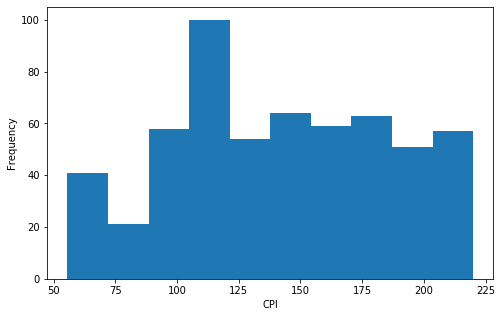

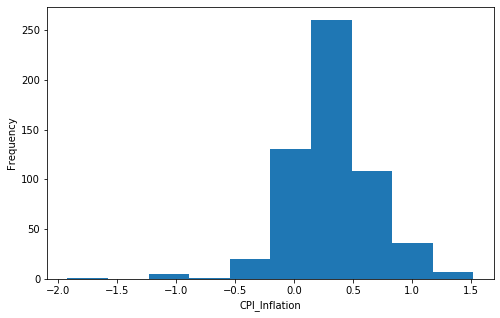

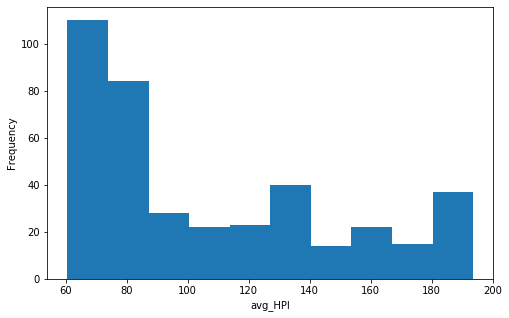

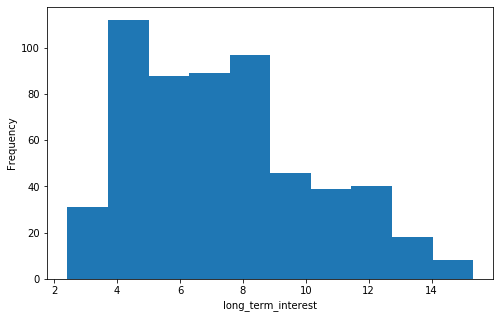

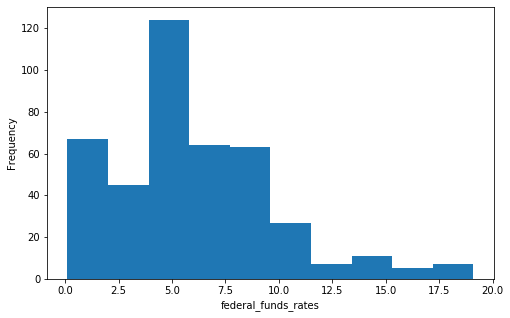

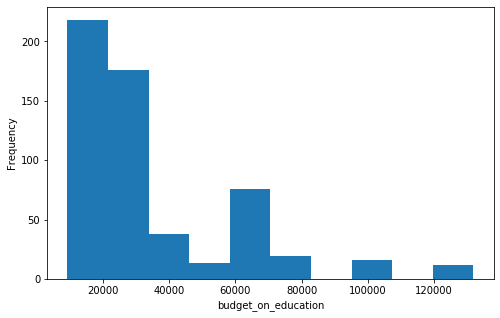

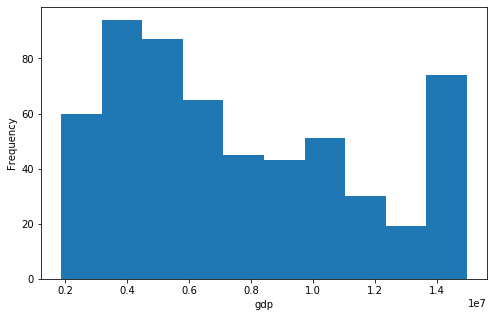

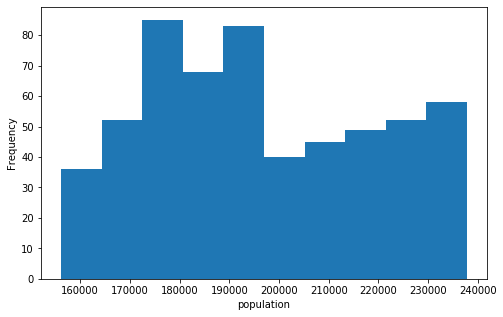

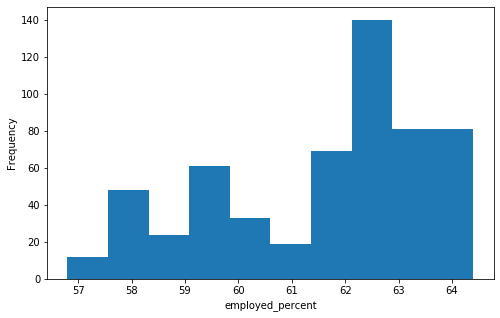

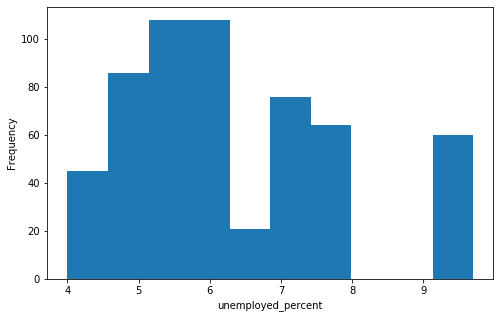

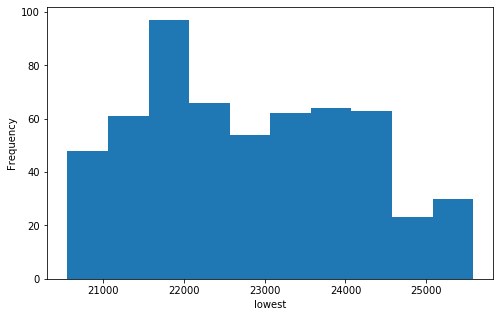

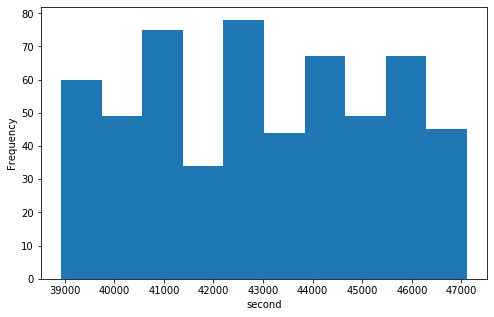

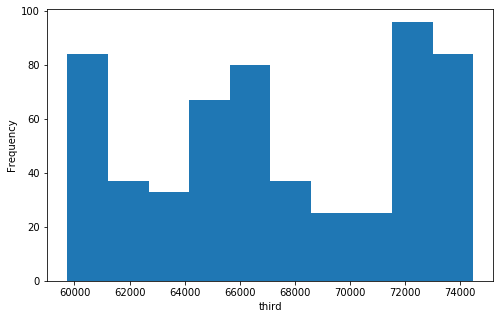

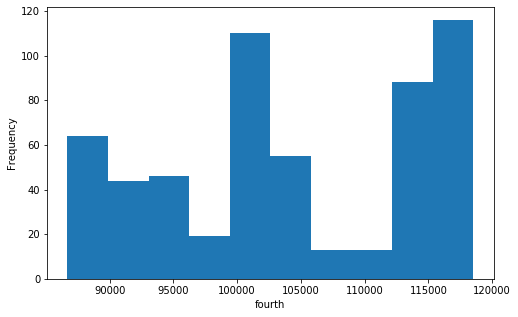

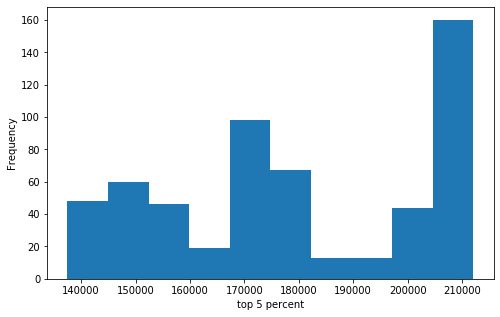

In [13]:
for col in df_model.columns:
    df_model[col].plot(kind='hist', figsize=(8, 5))
    plt.xlabel(col) # add x-label
    plt.savefig('Variables_Charts/' + col + '_hist.pdf')
    plt.show()

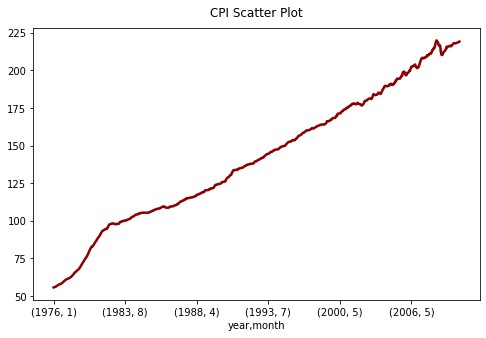

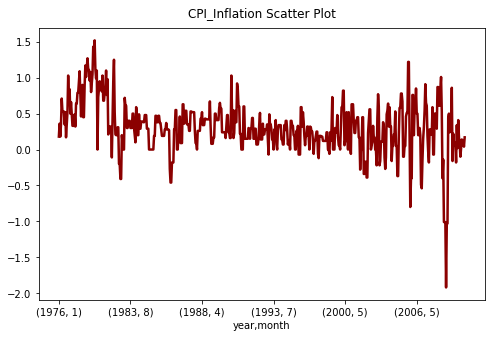

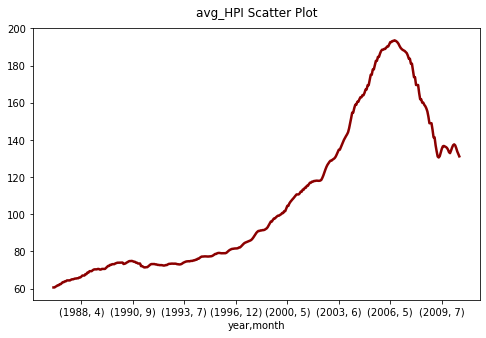

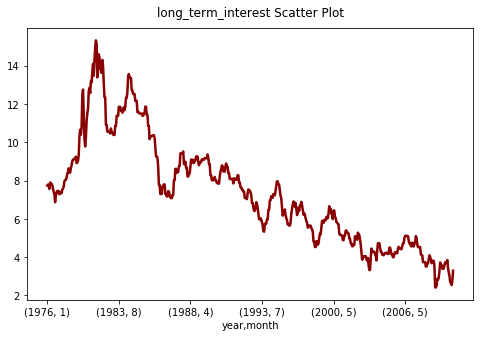

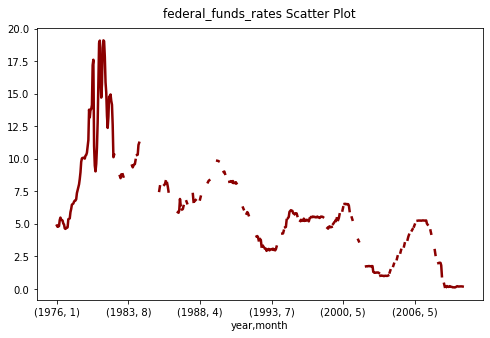

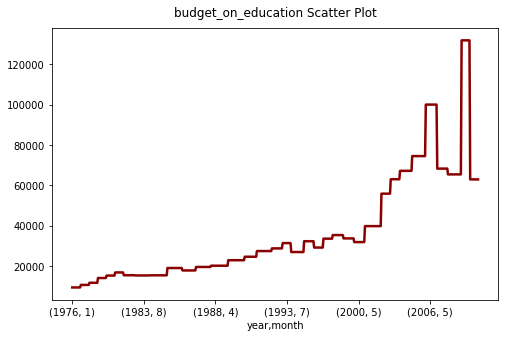

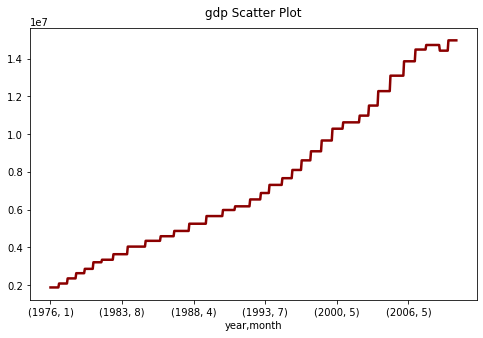

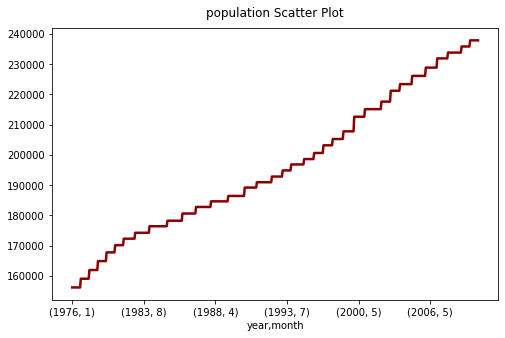

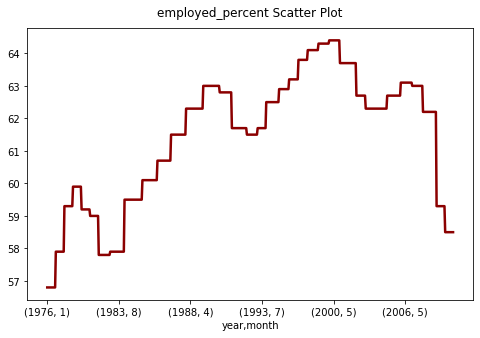

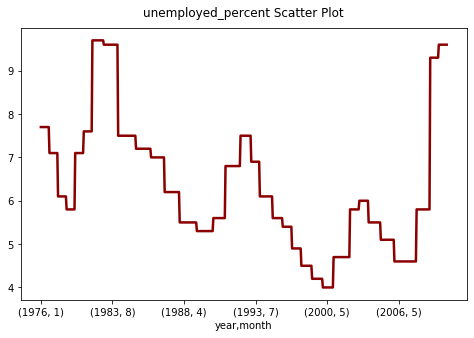

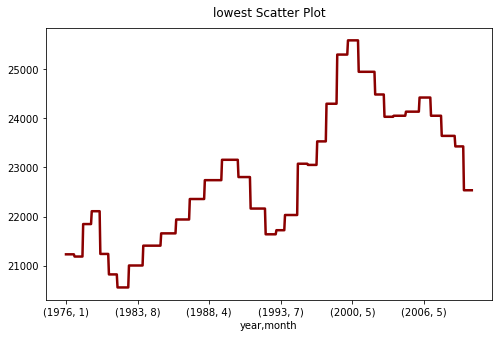

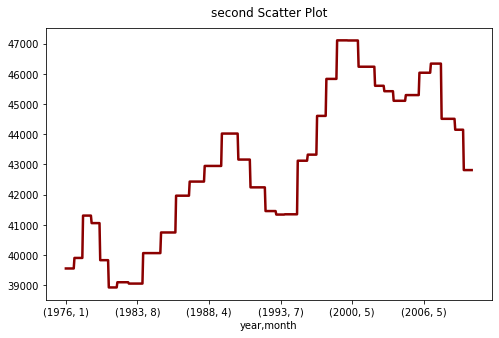

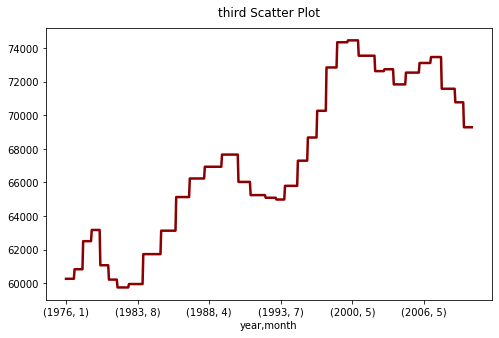

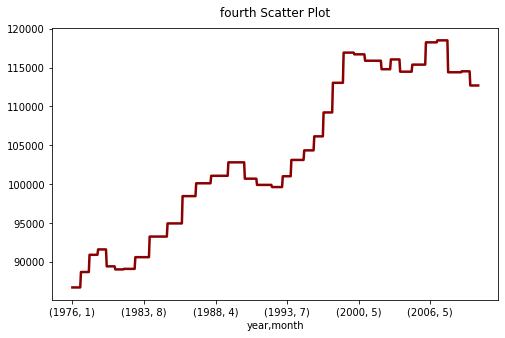

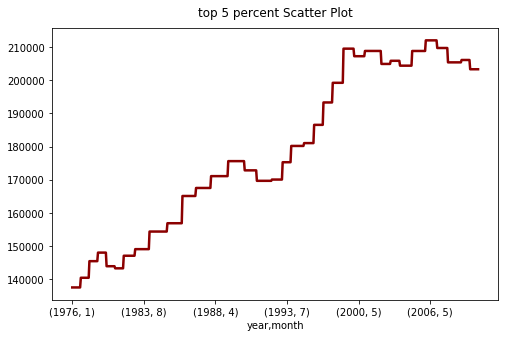

In [14]:
for col in df_model.columns:
    df_model[col].plot.line(figsize=(8, 5), linewidth=2.5, color='darkred')
    plt.title(col+" Scatter Plot", y=1.02, fontsize=12);
    plt.savefig('Variables_Charts/' + col + '_scatter.pdf')
    plt.show()